# Exploratory Data Analysis and Predictive Modeling for   Airbnb London listings

 

Airbnb is a global online marketplace and hospitality service with millions of listings. In this work, I analyse the Airbnb data in London to extract useful insights into listings characterists and rental landscapes. In addition, I apply the Random Forest Regressor to predict the price for property listings. 

## Data
The data is obtained from Inside Airbnb. Inside Airbnb is a crowd sourced listing website with publicly accessible data on Airbnb hosts, property listings, and reviews for different parts of the world.
The file Listings.csv contains detailed information about the amenities, prices, hosts and description, etc. of all the listings.

### Imports
Importing the neccessary libraries and packages

In [423]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import dates
from pprint import pprint
import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import csv
from ipyleaflet import Map, Heatmap, Marker, MarkerCluster
from random import uniform


from catboost import CatBoostRegressor

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline



In [358]:
listings = pd.read_csv('/Users/MarahFaroun/Downloads/listings.csv', low_memory=False)
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83850 entries, 0 to 83849
Columns: 106 entries, id to reviews_per_month
dtypes: float64(23), int64(21), object(62)
memory usage: 67.8+ MB


# Data Cleaning and Preparation and Feature Selection

Since the independent variable is the price, I drop the columns that do not much insight and fill in missing values, clean and transform the format of data in tho columns that have relatively strong relationship with the price. 


In [359]:
#Identify where most missing values are and drop corresponding columns
listings.isna().mean().sort_values(ascending=False)[:12]


thumbnail_url                   1.000000
neighbourhood_group_cleansed    1.000000
xl_picture_url                  1.000000
host_acceptance_rate            1.000000
medium_url                      1.000000
jurisdiction_names              0.999976
license                         0.997698
square_feet                     0.994693
monthly_price                   0.936458
weekly_price                    0.910733
notes                           0.609600
access                          0.446691
dtype: float64

In [361]:
#dropping the columns with mostly NaN values
listings = listings.drop(['jurisdiction_names', 'neighbourhood_group_cleansed', 'xl_picture_url', 'host_acceptance_rate',
                               'medium_url', 'thumbnail_url', 'license', 'square_feet', 'monthly_price', 'weekly_price',
                               'listing_url','amenities', 'scrape_id', 'last_scraped', 'calendar_updated', 'house_rules'], axis=1)

In [360]:
#dropping the columns that do not contribute to price prediction,
#dropping the columns with overlapping information,
#dropping the columns with textual data as NLP is not utilised
listings = listings.drop(['name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
                                'picture_url', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                                'host_neighbourhood', 'city', 'street', 'neighbourhood', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country',
                                 'calendar_last_scraped', 'host_verifications', 'is_location_exact', 'host_since', 'first_review',
                                'last_review', 'number_of_reviews_ltm', 'reviews_per_month'], axis=1)

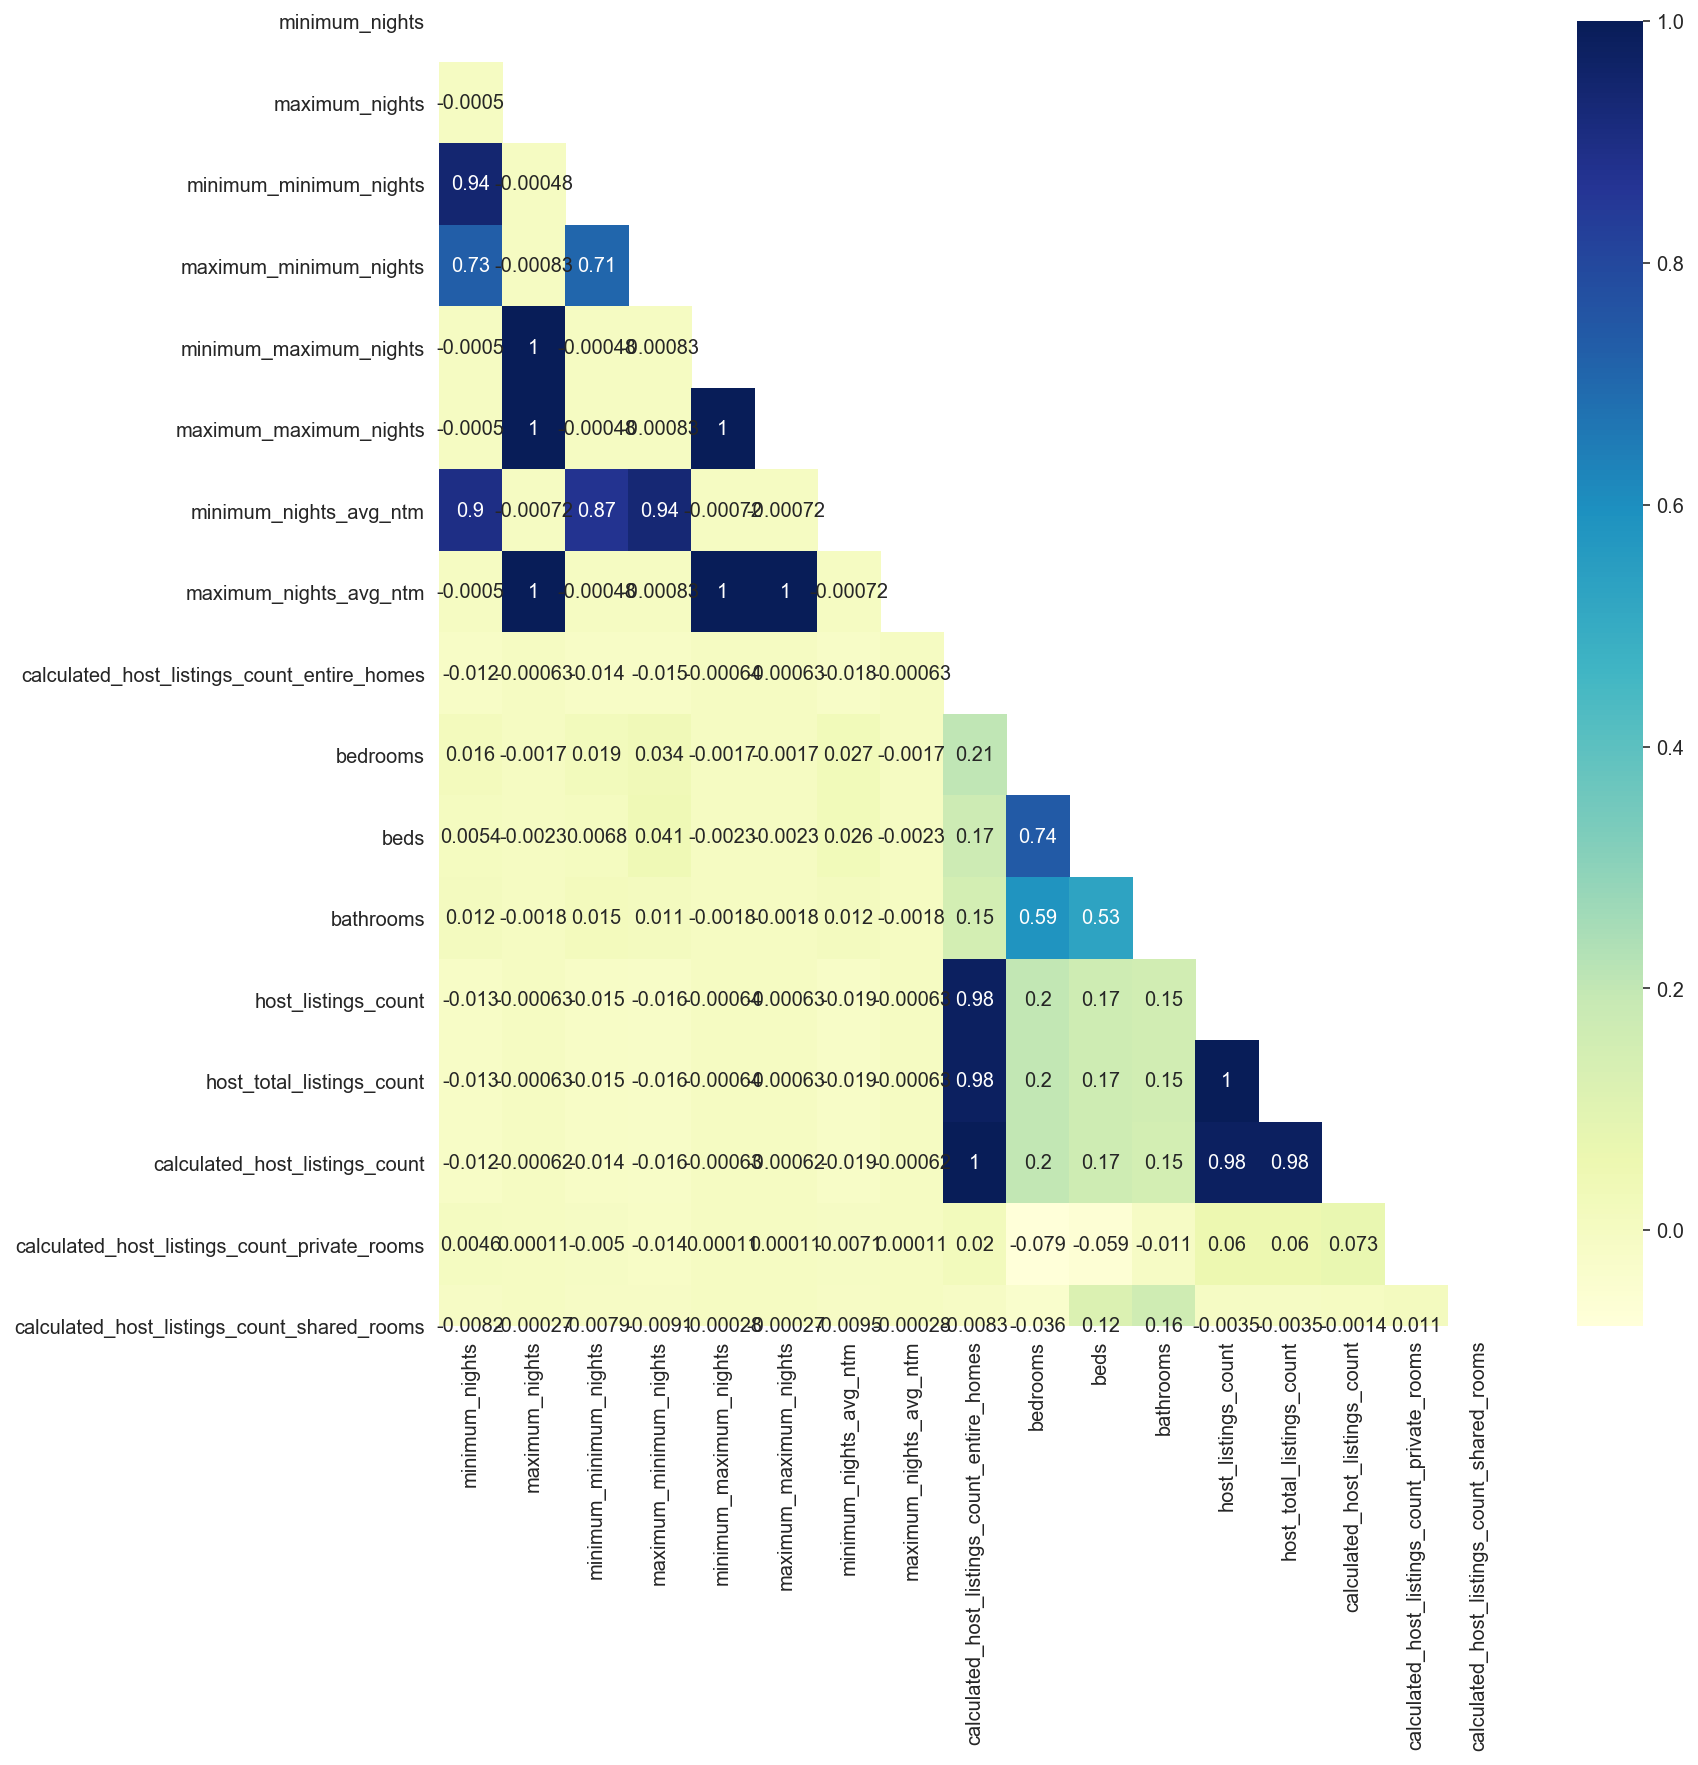

In [366]:
#identify highly correlated data to drop corresponding columns
corr_columns = ['minimum_nights', 'maximum_nights',
              'minimum_minimum_nights', 'maximum_minimum_nights',
              'minimum_maximum_nights', 'maximum_maximum_nights',
              'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
              'calculated_host_listings_count_entire_homes', 
              'bedrooms', 'beds', 'bathrooms', 'host_listings_count', 'host_total_listings_count',
              'calculated_host_listings_count', 'calculated_host_listings_count_private_rooms',
              'calculated_host_listings_count_shared_rooms',
              ]

listings_corr = listings[corr_columns].corr()
f, ax = plt.subplots(figsize = (12,12))
mask = np.zeros_like(listings_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(listings_corr, mask=mask, cmap='YlGnBu',  annot=True)


In [367]:
#dropping the columns of weakly correlated data
listings = listings.drop(['minimum_minimum_nights', 'maximum_minimum_nights',
                                'minimum_maximum_nights', 'maximum_maximum_nights',
                                'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
                                'host_total_listings_count', 'calculated_host_listings_count',
                                'calculated_host_listings_count_entire_homes',
                                'calculated_host_listings_count_private_rooms',
                                'calculated_host_listings_count_shared_rooms'], axis=1)

# -- Property Availability --

In [368]:
#all of the properties are available (has only one category True) so we drop the column
listings['has_availability'].value_counts()


t    83850
Name: has_availability, dtype: int64

In [369]:
listings.drop('has_availability', axis=1) 

,id,experiences_offered,host_id,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,13913,business,54730,within a few hours,0.86,f,4.0,t,f,Islington,...,9.0,10.0,9.0,9.0,f,f,f,moderate,f,f
1,15400,romantic,60302,within a day,1.00,t,1.0,t,t,Kensington and Chelsea,...,10.0,10.0,10.0,9.0,f,f,f,strict_14_with_grace_period,t,t
2,17402,none,67564,within an hour,0.85,t,19.0,t,t,Westminster,...,9.0,9.0,10.0,9.0,f,t,f,strict_14_with_grace_period,f,f
3,24328,family,41759,within a day,1.00,f,2.0,t,t,Wandsworth,...,10.0,10.0,9.0,9.0,f,f,f,moderate,t,t
4,25023,none,102813,within a few hours,1.00,f,1.0,t,f,Wandsworth,...,9.0,9.0,9.0,9.0,f,f,f,moderate,f,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83845,36583878,none,90770681,within a day,0.67,f,1.0,t,f,Westminster,...,NaN,NaN,NaN,NaN,f,f,f,moderate,f,f
83846,36584535,none,47609036,within a few hours,1.00,f,17.0,t,f,Islington,...,NaN,NaN,NaN,NaN,f,f,f,flexible,f,f
83847,36585425,none,47609036,within a few hours,1.00,f,17.0,t,f,Islington,...,NaN,NaN,NaN,NaN,f,f,f,flexible,f,f
83848,36585645,none,47609036,within a few hours,1.00,f,17.0,t,f,Islington,...,NaN,NaN,NaN,NaN,f,f,f,flexible,f,f


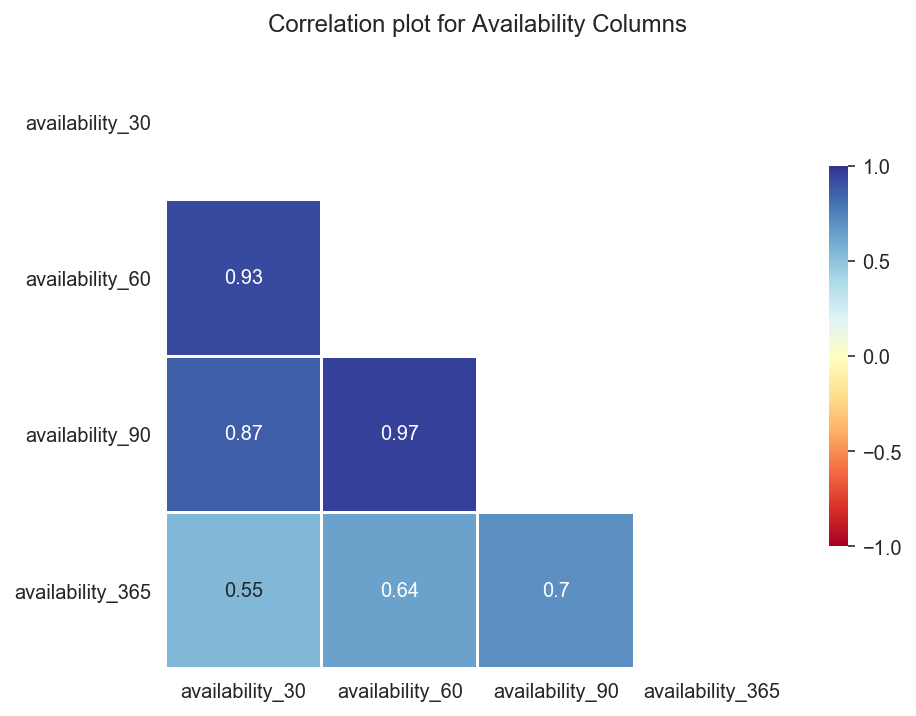

In [370]:
#Identifying the correlation between the following availability columns
avail_columns = ['availability_30', 'availability_60', 'availability_90', 'availability_365' ]
avail_corr = listings[avail_columns].corr()
f, ax = plt.subplots(figsize = (7,7))
mask = np.zeros_like(avail_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(avail_corr,  mask=mask, square=True, linewidths=.9, cmap='RdYlBu',annot=True, cbar_kws={'shrink': .5,
                                    'ticks': [-1, -.5, 0, 0.5, 1]}, vmin=-1, vmax=1)
ax.set_yticklabels(avail_corr.columns, rotation=0)
ax.set_xticklabels(avail_corr.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.title('Correlation plot for Availability Columns')
plt.ylim(b, t) 
plt.show() 


In [371]:
#they are highly correlated so I keep only one column
listings = listings.drop(['availability_30', 'availability_60', 'availability_365'], axis=1)

# -- Bed Types --

In [372]:
listings['bed_type'].value_counts()


Real Bed         83115
Pull-out Sofa      428
Futon              188
Couch               72
Airbed              47
Name: bed_type, dtype: int64

In [373]:
#majority of bed types are real beds, so I drop this column
listings = listings.drop(columns='bed_type')
listings = listings.drop(columns='beds')

# -- Experience offered --


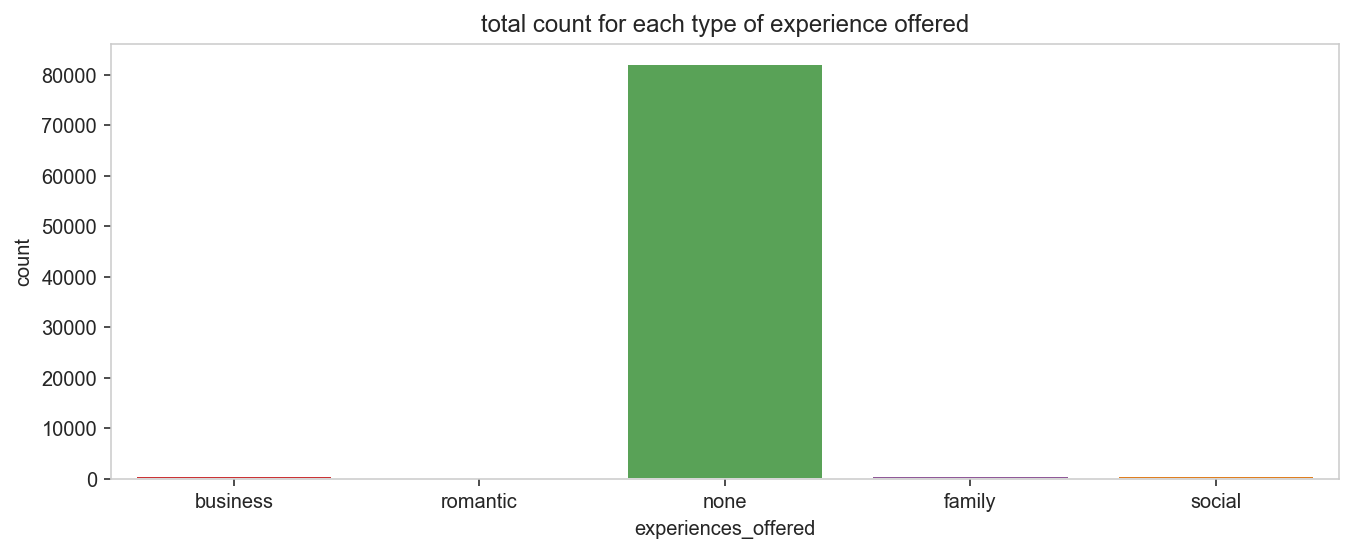

In [374]:
#plotting the number of properties according to the experience offered
fig, ax = plt.subplots(figsize=(11,4))
countplot = sns.countplot(x='experiences_offered', hue=None, data=listings, palette="Set1")
ax.set_title(f'total count for each type of experience offered')
ax.grid(False)
plt.show()


In [375]:
#majority of listings did not have information regarding the type of experience provided
#thus, I drop the experiences_offered column
listings = listings.drop(['experiences_offered'], axis=1)

# -- Price Distribution per Neighbourhood --

In [362]:
#removing the dollar sign from price and extra costs and filling NaN values
cost_cols = [ 'price', 'security_deposit', 'cleaning_fee','extra_people']

listings[cost_cols] = listings[cost_cols].apply(lambda x: x.str[1:], axis=0)
listings[cost_cols]= listings[cost_cols].apply(
        lambda x: x.str.replace(",", '')).astype('float64')
listings[cost_cols] = listings[cost_cols].fillna(value=0)

In [363]:
listings['price'].dtype

dtype('float64')

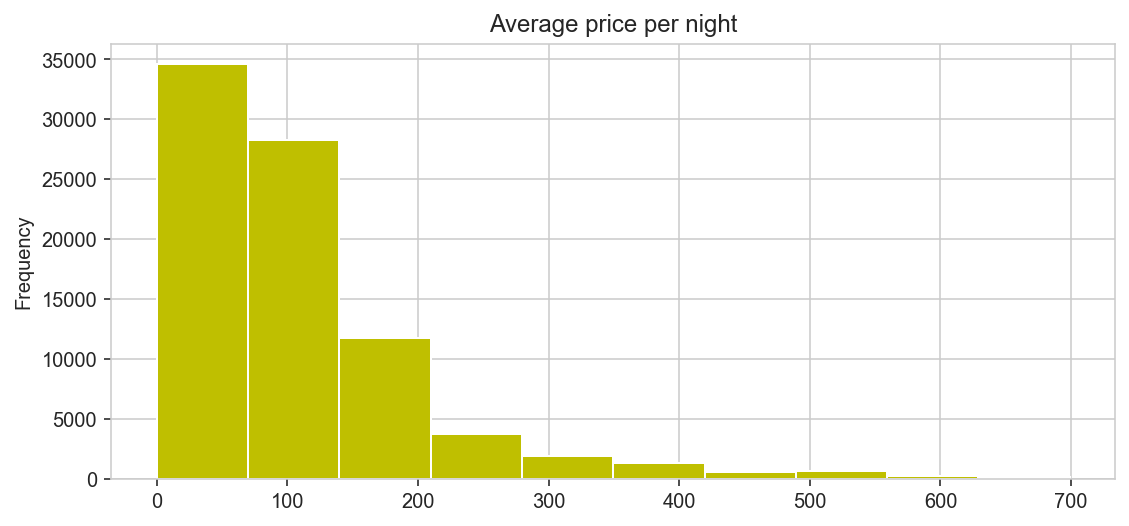

In [378]:
#plotting a histogram of the price of properties (Y axis is number of properties)
listings['price'][listings['price'] < 700].plot(kind='hist', color = 'y', figsize=(9,4))
plt.title(f'Average price per night')
plt.grid(True)

In [376]:
listings.neighbourhood_cleansed.unique()


array(['Islington', 'Kensington and Chelsea', 'Westminster', 'Wandsworth',
       'Barnet', 'Newham', 'Hounslow', 'Camden', 'Richmond upon Thames',
       'Haringey', 'Hackney', 'Croydon', 'Tower Hamlets',
       'Hammersmith and Fulham', 'Southwark', 'Waltham Forest', 'Brent',
       'Lambeth', 'Ealing', 'Merton', 'Lewisham', 'Bromley', 'Havering',
       'Greenwich', 'Enfield', 'City of London', 'Barking and Dagenham',
       'Hillingdon', 'Harrow', 'Redbridge', 'Kingston upon Thames',
       'Bexley', 'Sutton'], dtype=object)

In [379]:
#create a dataframe containing neighborhood, price, and reviews per property
custom = lambda x: np.average(x)
neighbor_df = pd.DataFrame(listings.groupby('neighbourhood_cleansed').agg({'number_of_reviews':'sum', 'review_scores_rating': 'mean', 'price':custom}))


In [380]:
neighbor_df = neighbor_df.reset_index(level = 0)
neighbor_df.sort_values('neighbourhood_cleansed',inplace=True)
neighbor_df = neighbor_df.reset_index()
neighbor_df

,index,neighbourhood_cleansed,number_of_reviews,review_scores_rating,price
0,0,Barking and Dagenham,2295,92.156098,62.537092
1,1,Barnet,17540,93.995112,85.273304
2,2,Bexley,1602,90.801370,54.428571
3,3,Brent,40093,92.626034,89.313511
4,4,Bromley,6763,92.139738,63.606825
5,5,Camden,119865,91.548626,144.683311
6,6,City of London,7645,91.306502,175.285408
7,7,Croydon,12295,93.691989,63.325346
8,8,Ealing,28516,93.814416,79.483929
9,9,Enfield,6279,93.775862,62.815166


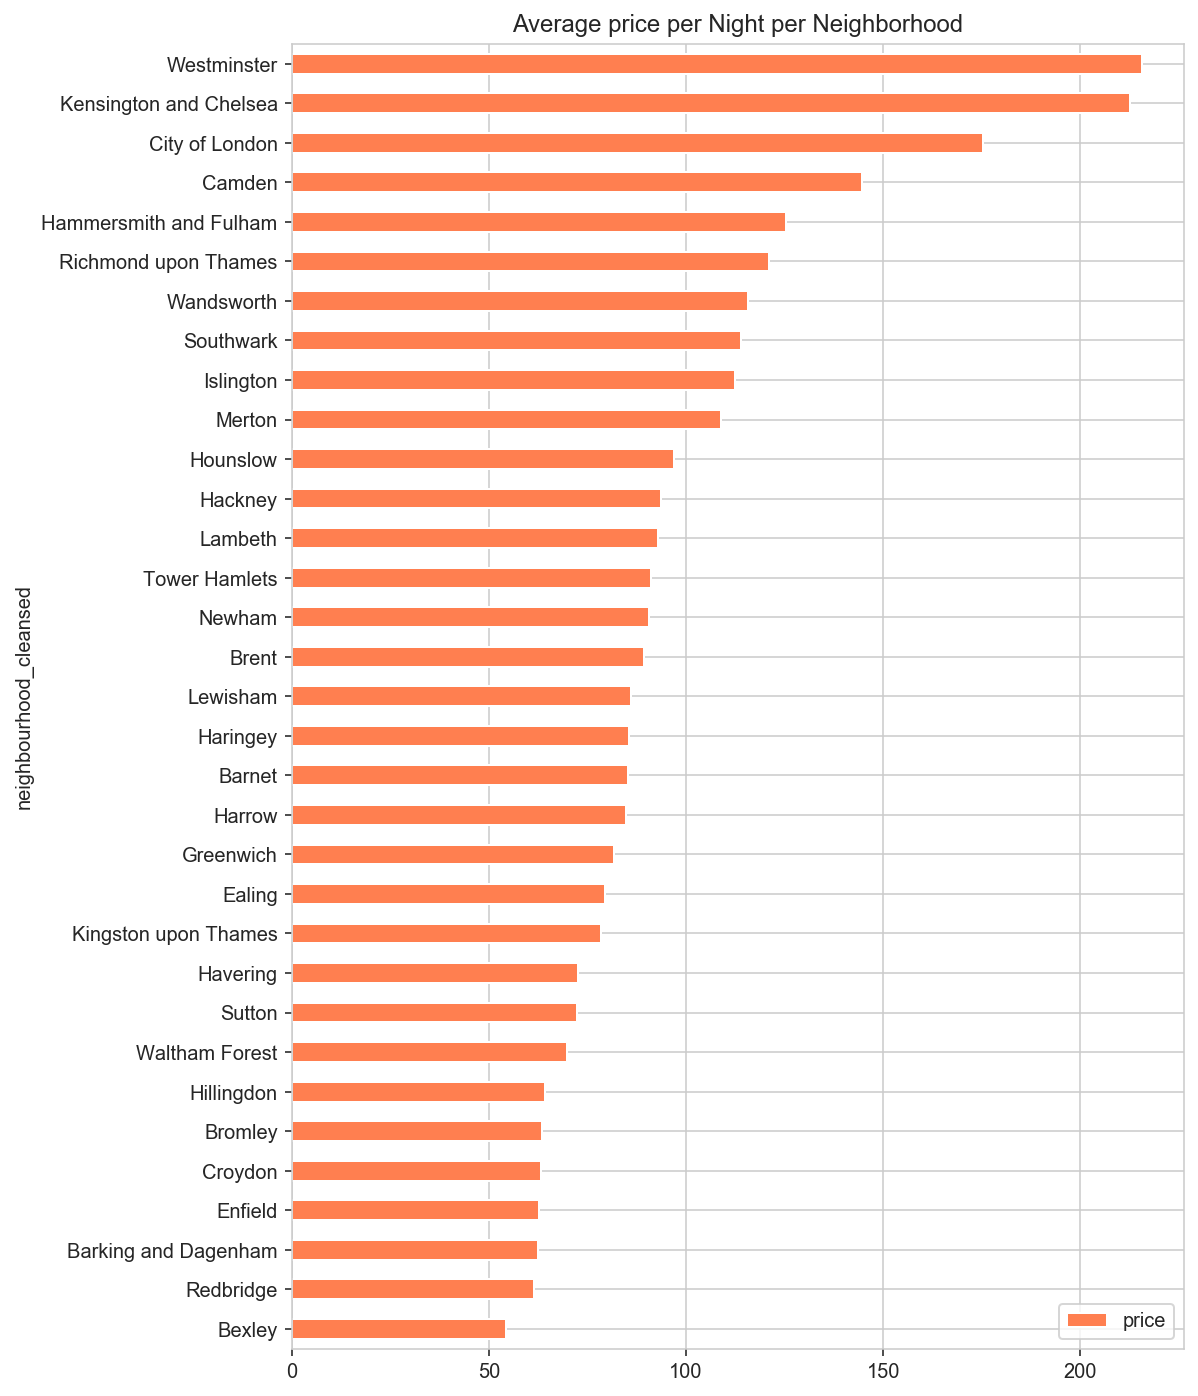

In [381]:
#obtaining the average price per night per property and plotting their rank accordingly
x = neighbor_df.sort_values(by='price', ascending=False)
x.plot(x = 'neighbourhood_cleansed', y = ['price'] , kind ='barh',  figsize =(8, 12), color = 'coral')
plt.gca().invert_yaxis()
plt.title(f'Average price per Night per Neighborhood')
plt.grid(True)

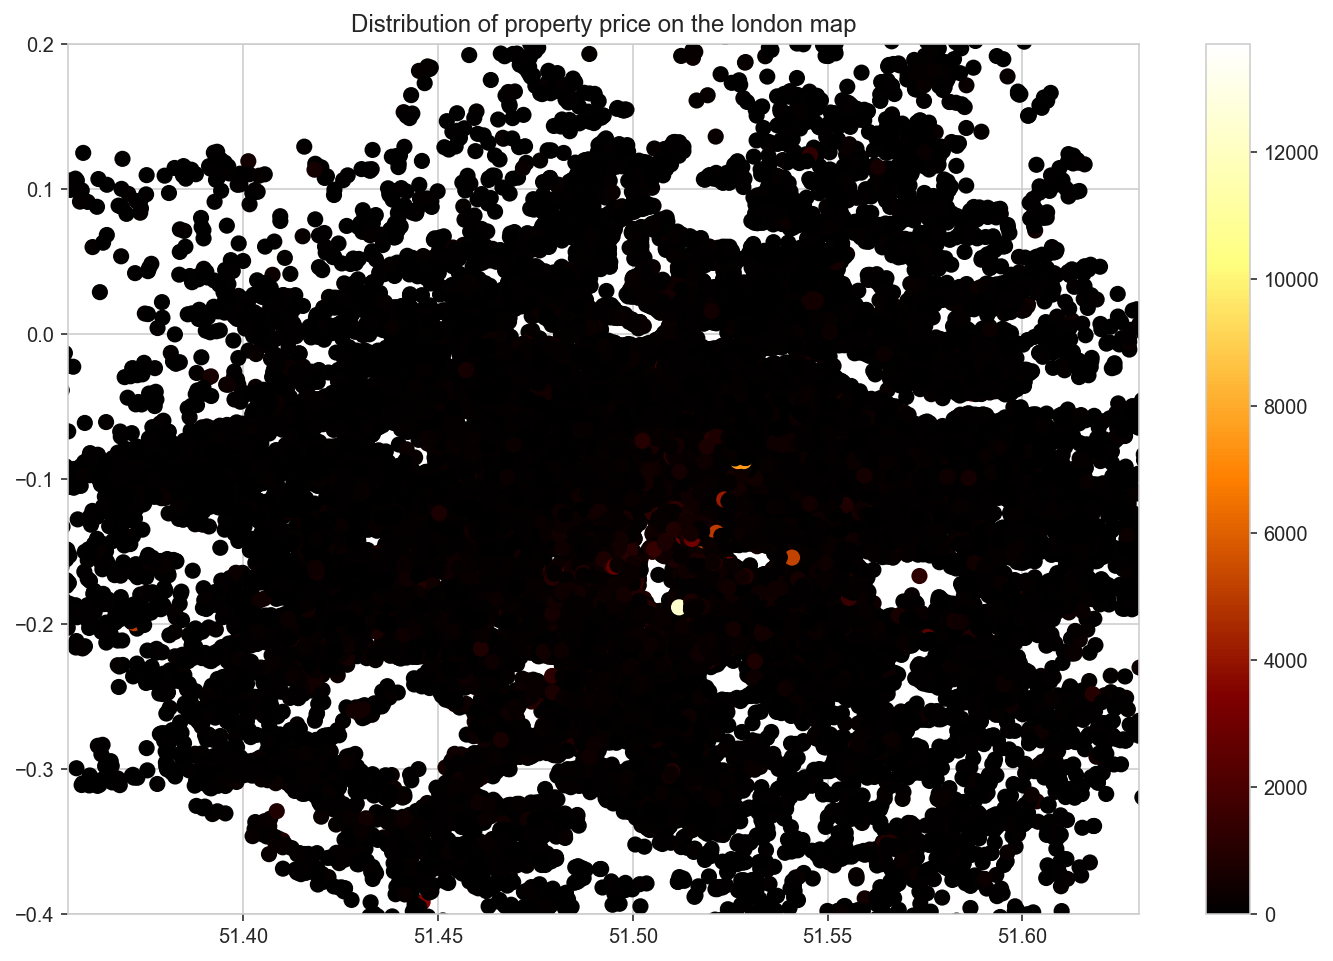

In [382]:
#plotting the distribution of average property nightly price on the london map by neighborhood
#across latitudes and longitudes
plt.figure(figsize=(12,8))          
price_map = plt.scatter(listings['latitude'], listings['longitude'], c=listings["price"], s=50, cmap="afmhot") 
plt.colorbar(price_map)
plt.ylim([-0.4, 0.2])
plt.xlim([51.355, 51.63])
plt.title(f'Distribution of property price on the london map')
plt.grid(True)

# -- Price Distribution per Accomondation Type --

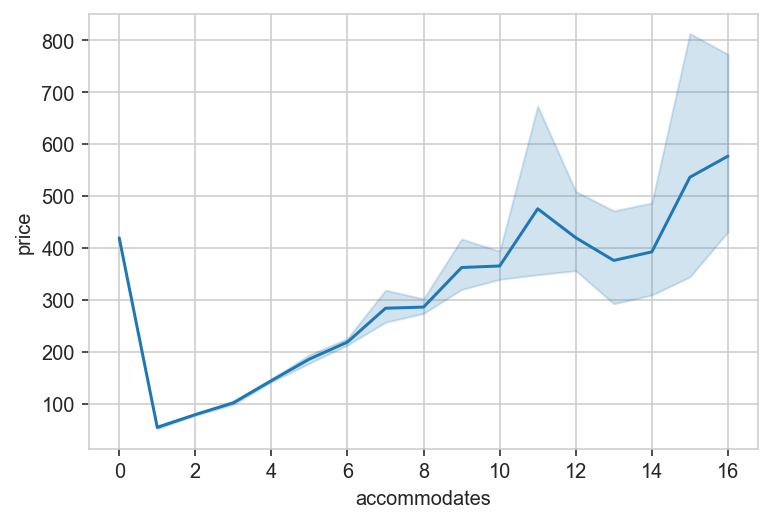

In [383]:
#the more people the property accomodates, the more expensive it is per night
sns.lineplot(x="accommodates", y="price", data=listings)


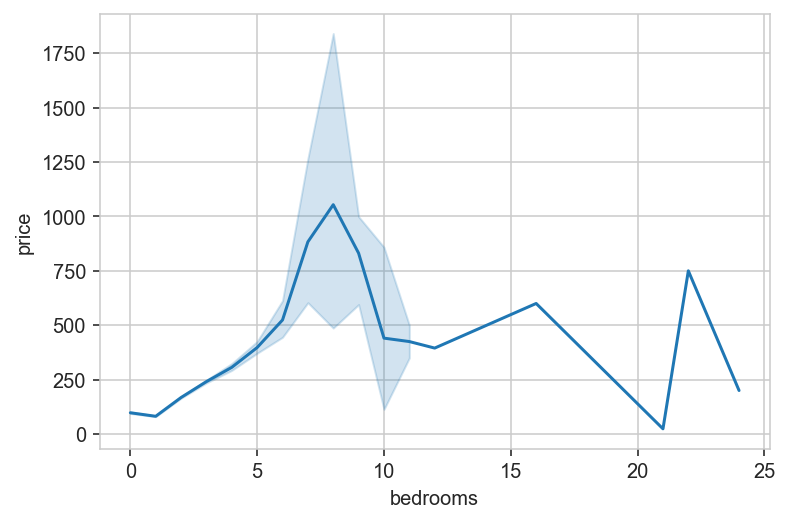

In [384]:
#the price increases as the number of rooms in the property increases up to 8 rooms.
sns.lineplot(x="bedrooms", y="price", data=listings)

# -- Reviews --

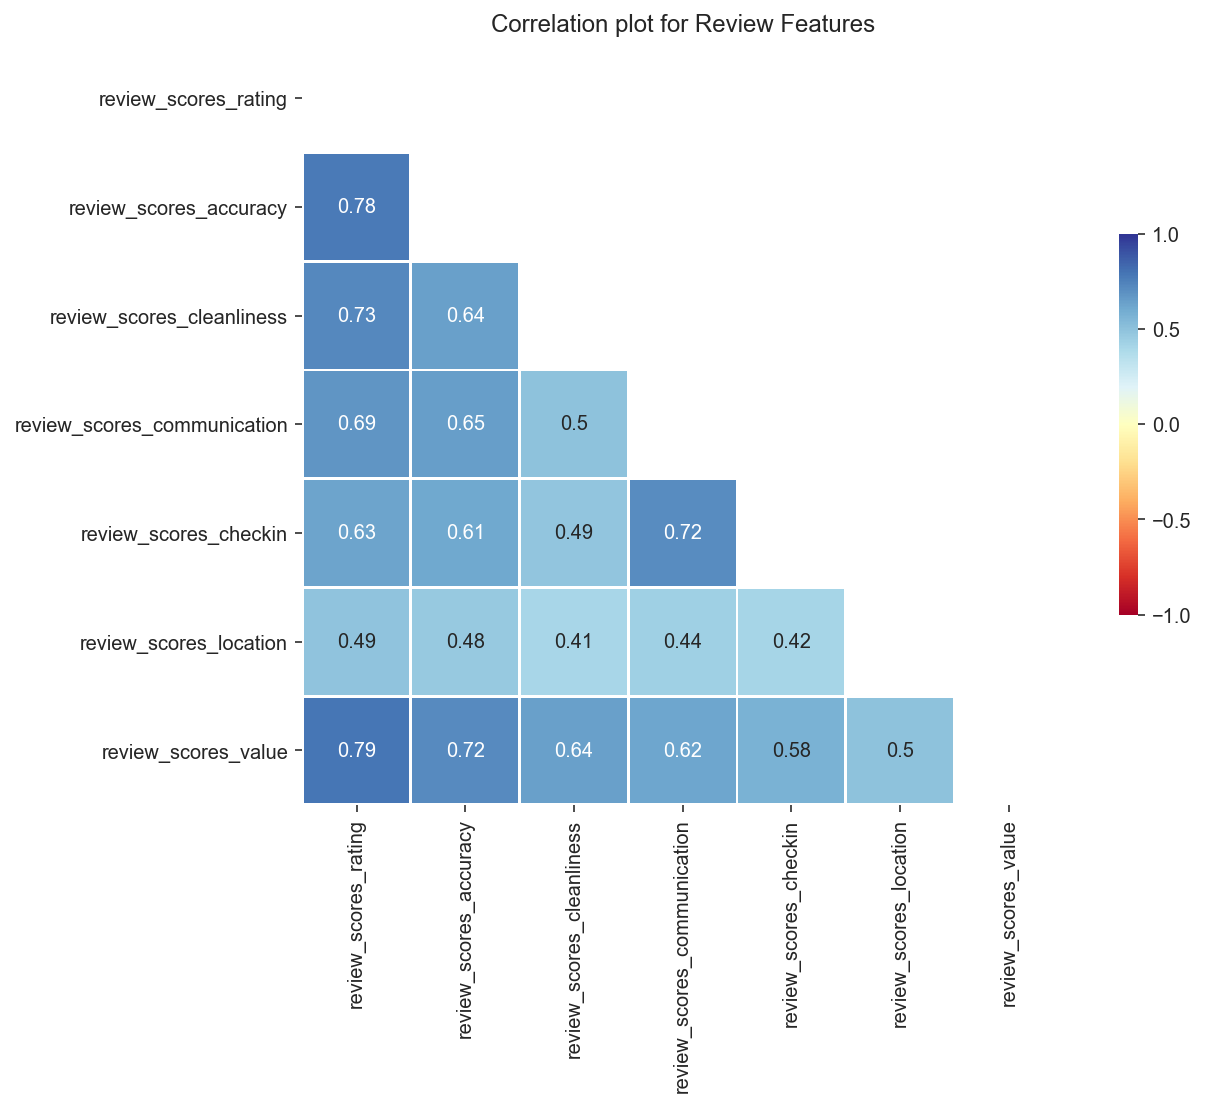

In [385]:
#plotting the correlation matrix for columns describing reviews
review_cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                  'review_scores_communication', 'review_scores_checkin', 'review_scores_location', 'review_scores_value']
review_corr = listings[review_cols].corr()
f, ax = plt.subplots(figsize = (10,7))
mask = np.zeros_like(review_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(review_corr,  mask=mask, square=True, linewidths=.9, cmap='RdYlBu',annot=True, cbar_kws={'shrink': .5,
                                    'ticks': [-1, -.5, 0, 0.5, 1]}, vmin=-1, vmax=1)
ax.set_yticklabels(review_corr.columns, rotation=0)
ax.set_xticklabels(review_corr.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.title('Correlation plot for Review Features')
plt.ylim(b, t) 
plt.show() 



In [386]:
#all of the review features are closely positively correlated. 
#Therefore, we will leave only one column and drop the rest.
cols_to_drop = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_value',
                   'review_scores_communication', 'review_scores_checkin', 'review_scores_location']
listings = listings.drop(cols_to_drop, axis=1)

# -- Reviews Count by Neighborhood --

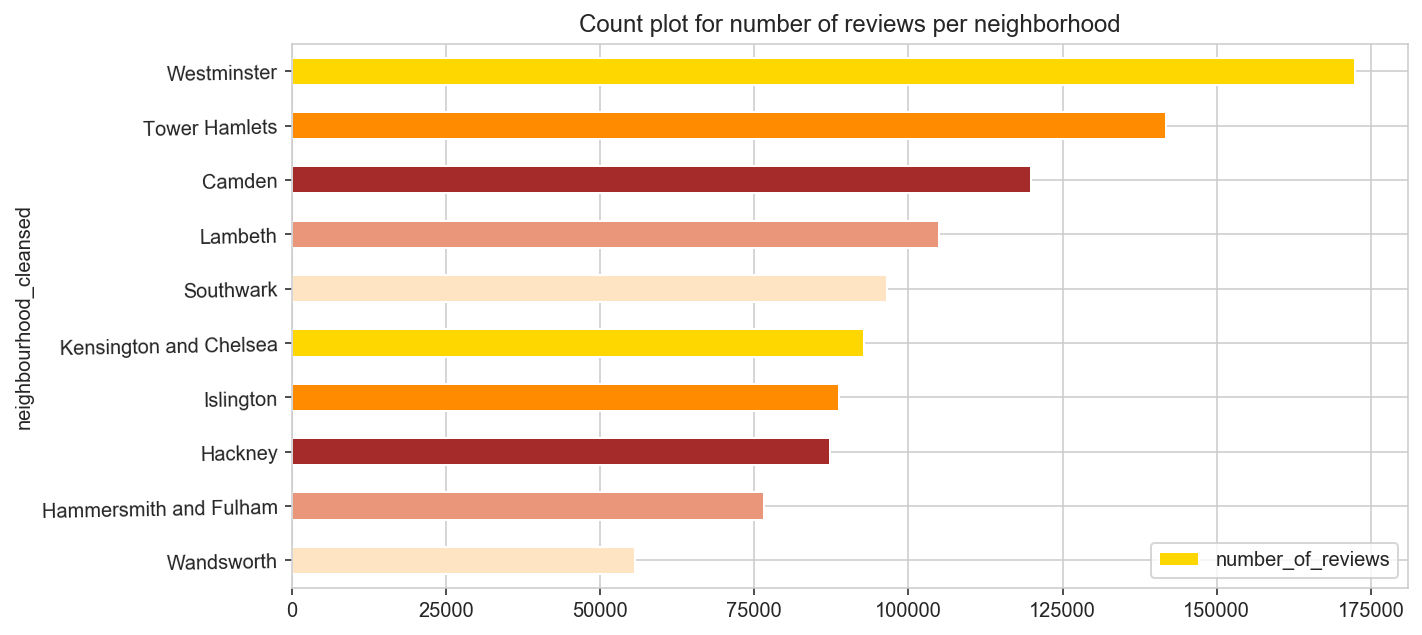

In [388]:
#Idnentifying which neighborhoods get the most number of property reviews on airbnb 
#alot of the properties with the highest reviews are also amongst the most expensive ones
x = neighbor_df.sort_values(by='number_of_reviews', ascending=False).head(10)
x.plot(x = 'neighbourhood_cleansed', y = 'number_of_reviews', kind = 'barh', rot=1, color = ['gold', 'darkorange', 'brown', 'darksalmon', 'bisque'], figsize=(10,5))
plt.gca().invert_yaxis()
plt.title(f'Count plot for number of reviews per neighborhood')
plt.grid(True)

# -- Reviews Ratings by Neighborhood --

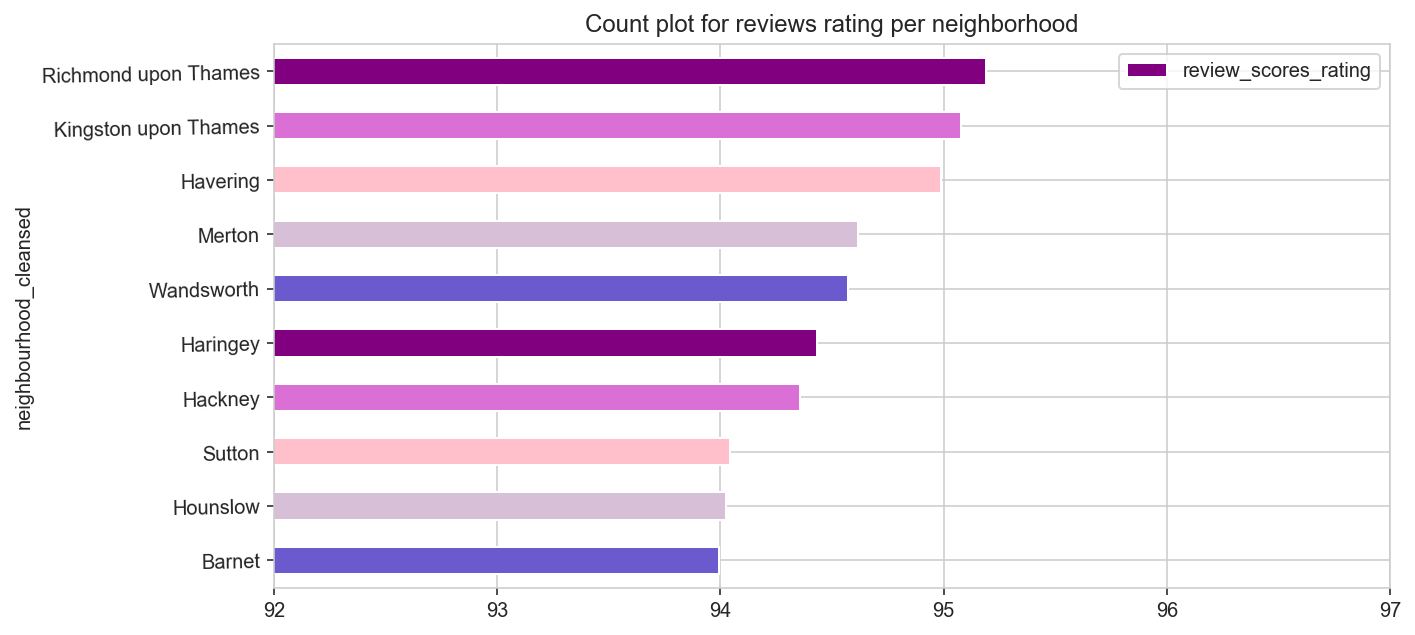

In [389]:
#Identifying which neighborhoods obtain the highest reviews rating
x = neighbor_df.sort_values(by='review_scores_rating', ascending=False).head(10)
x.plot(x = 'neighbourhood_cleansed', y = 'review_scores_rating', kind = 'barh', rot=1, color = ['purple', 'orchid', 'pink', 'thistle' ,'slateblue'], figsize=(10,5))
plt.gca().invert_yaxis()
plt.xlim([92, 97])
#plt.xlim([51.355, 51.63])
plt.title(f'Count plot for reviews rating per neighborhood')
plt.grid(True)

# -- Host Response Time --

In [364]:
#removing the % sign from host response rate
host_response_col = ['host_response_rate']
listings['host_response_rate'] = listings['host_response_rate'].str.strip('%')
listings['host_response_rate']= listings['host_response_rate'].astype(np.float64) / 100

In [365]:
listings['host_response_rate'].dtype

dtype('float64')

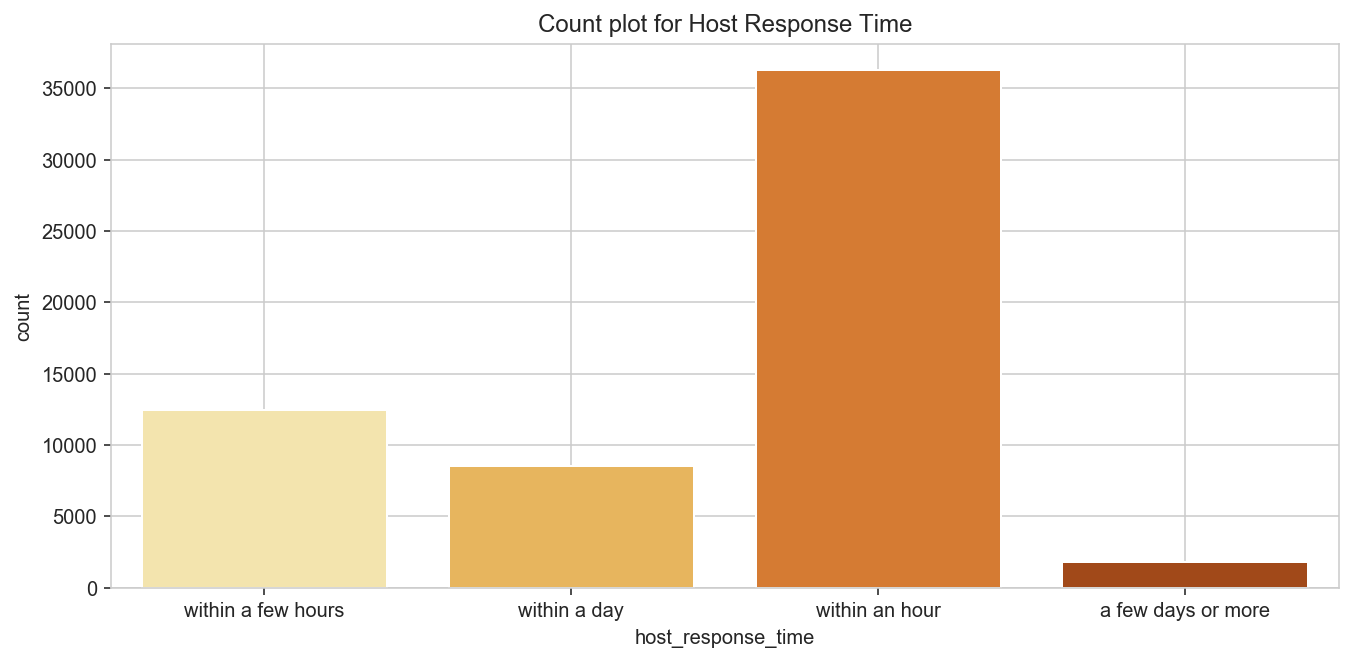

In [390]:
#plotting a barplot of the count of host response times
#the majority of hosts reply within an hour
plt.figure(figsize=(11,5))  
listings['host_response_time'].value_counts()
sns.countplot(listings['host_response_time'], palette = 'YlOrBr')
plt.title(f'Count plot for Host Response Time')
plt.grid(True)


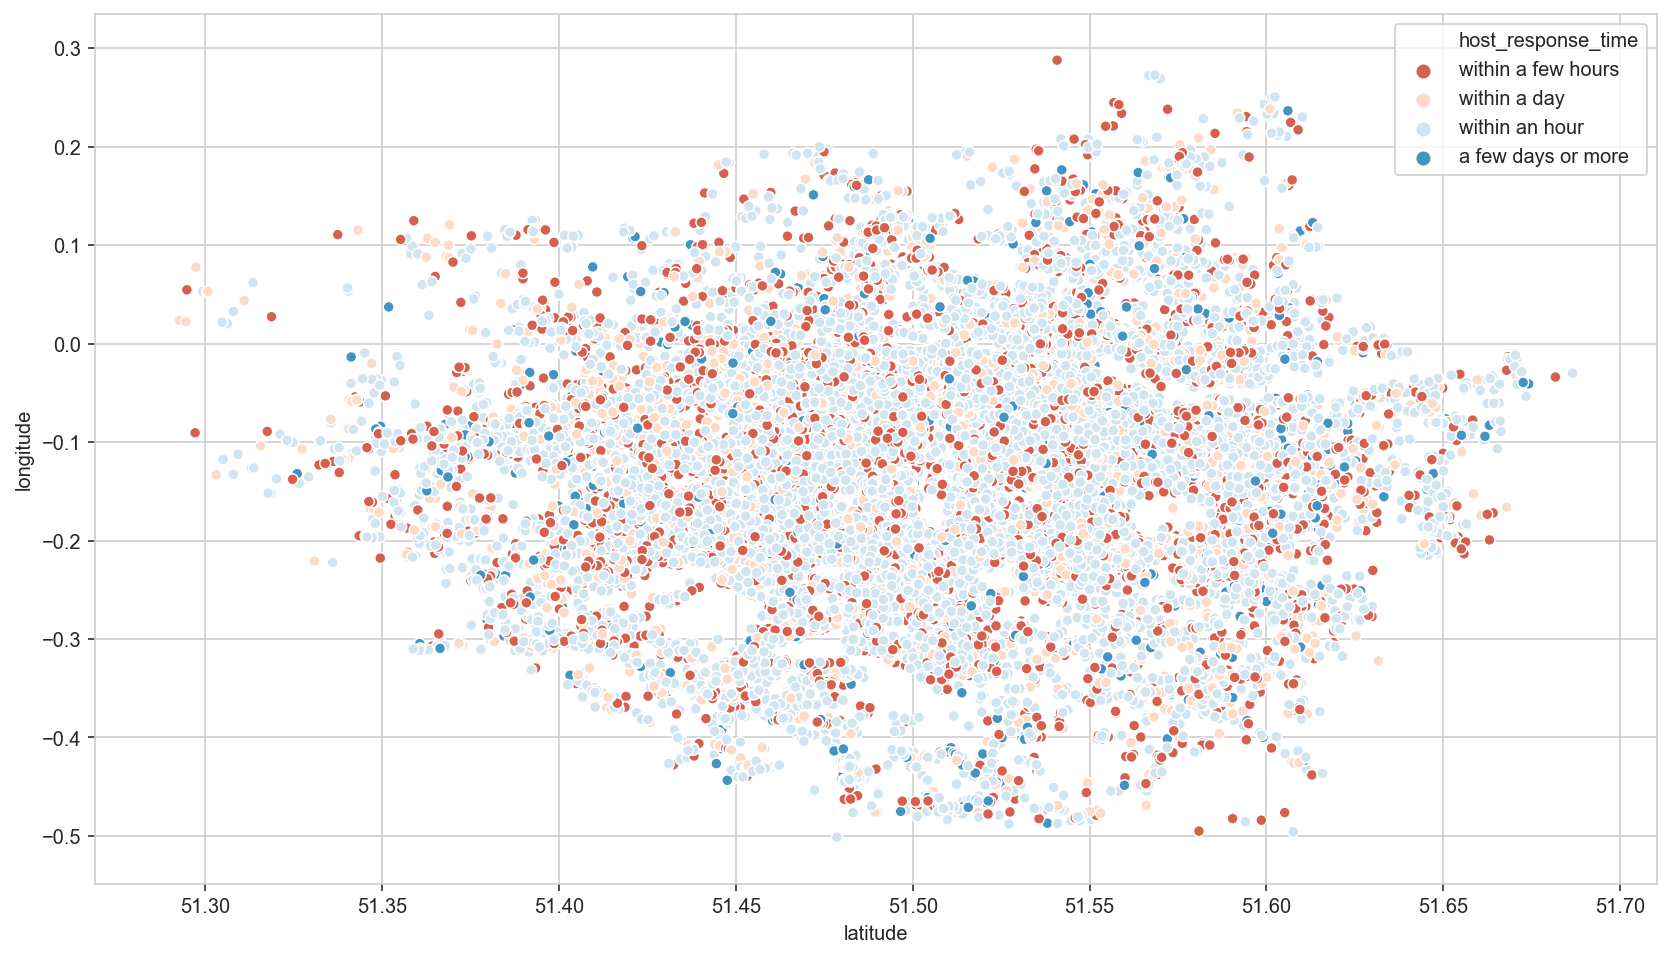

In [391]:
#a scatterplot showing the location of properties whos hosts have the following response time
# the majority of repsonse time of a few days or more (dark blue) is outside of central london
plt.figure(figsize=(14,8))
sns.scatterplot(x=listings['latitude'], y=listings['longitude'], hue=listings["host_response_time"], s=30, palette="RdBu")


Text(0.5, 1, 'Stripplot comparing superhosts and review ratings')

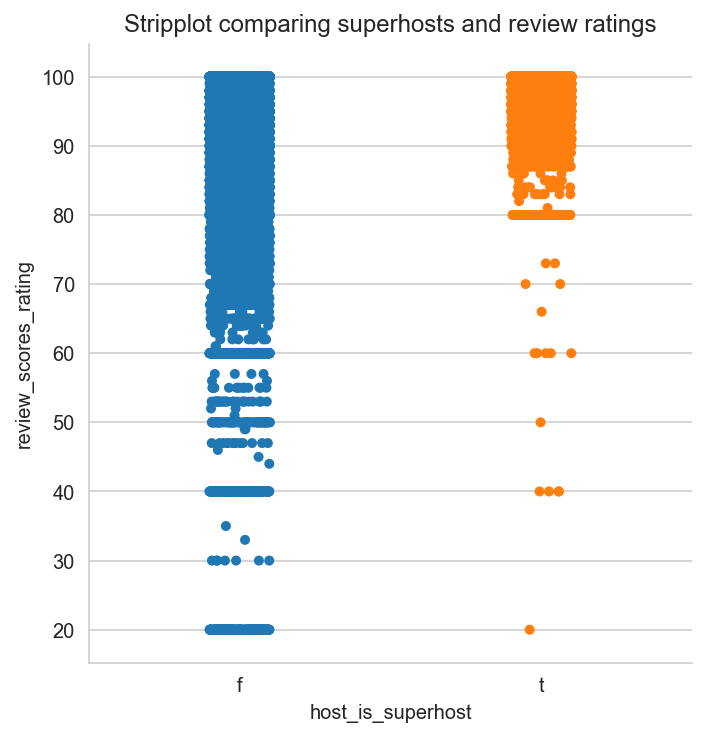

In [507]:
sns.catplot(x="host_is_superhost", y="review_scores_rating", data=listings)
plt.title('Stripplot comparing superhosts and review ratings')

# -- Room Type --

In [514]:
#majority of properties are rented as entire home/apartment 
listings['room_type'].value_counts()

Entire home/apt    47119
Private room       35948
Shared room          736
Name: room_type, dtype: int64

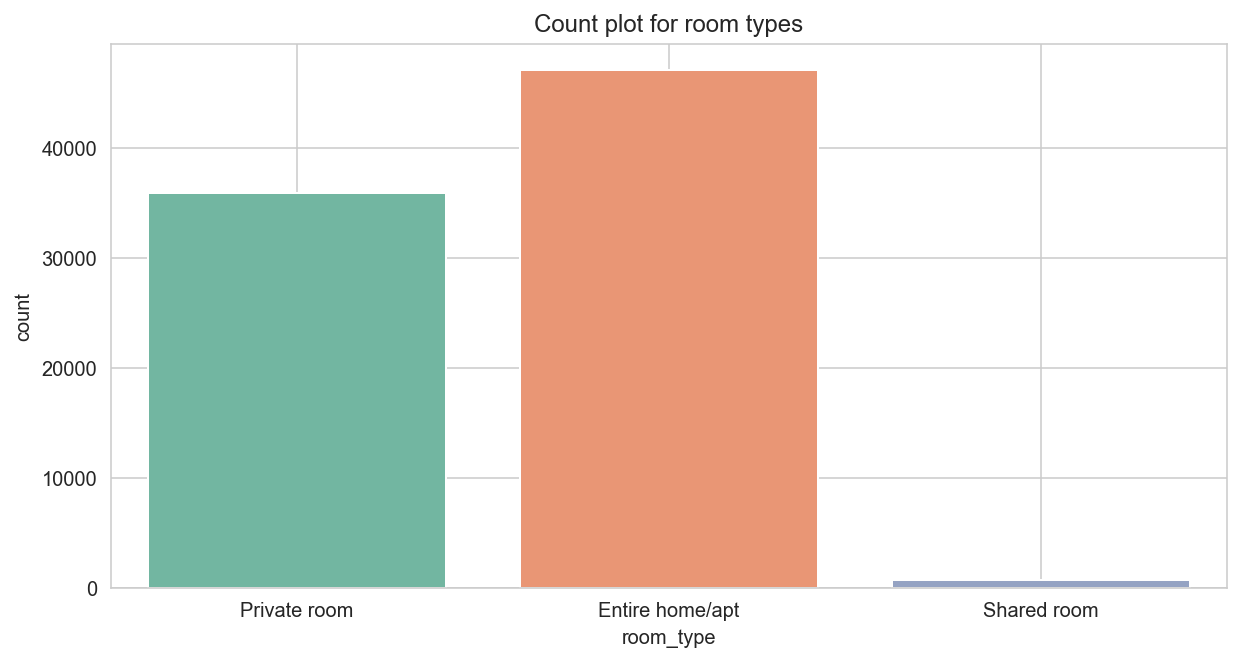

In [515]:
#plotting the count of room types
fig, ax = plt.subplots(figsize= (10,5))
cnt_plot = sns.countplot(x = 'room_type', data=listings, palette = 'Set2')
ax.set_title(f'Count plot for room types')
ax.grid(True)

# -- Property type --

In [393]:
listings['property_type'].value_counts()


Apartment                 56802
House                     17436
Townhouse                  2979
Serviced apartment         1896
Condominium                1107
Bed and breakfast           877
Loft                        715
Guest suite                 356
Guesthouse                  279
Hostel                      231
Boutique hotel              222
Other                       206
Hotel                       151
Bungalow                    132
Cottage                      83
Villa                        63
Boat                         57
Aparthotel                   54
Tiny house                   43
Houseboat                    30
Cabin                        24
Casa particular (Cuba)       21
Camper/RV                    17
Barn                         12
Chalet                       12
Earth house                  10
Hut                           9
Yurt                          4
Farm stay                     4
Dome house                    3
Treehouse                     2
Bus     

In [508]:
# I clean and combine all of property types into 4 types (house, apartment, guesthouse, and hotel)
listings.property_type.replace({
    'Townhouse': 'House',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Chalet': 'House',
    'Earth house': 'House',
    'Dome house': 'House',
    'Aparthotel': 'Hotel',
    'Boutique hotel': 'Hotel',
    'Aparthotel': 'Hotel',
    'Serviced apartment': 'Apartment',
    'Condominium': 'Apartment',
    'Loft': 'Apartment',
    'Bed and breakfast': 'Guesthouse',
    'Guest suite': 'Guesthouse',
    'Hostel': 'Guesthouse',
}, inplace=True)

In [395]:
listings.loc[~listings.property_type.isin(['House', 'Apartment', 'Guesthouse', 'Hotel']), 'property_type'] = 'Other'

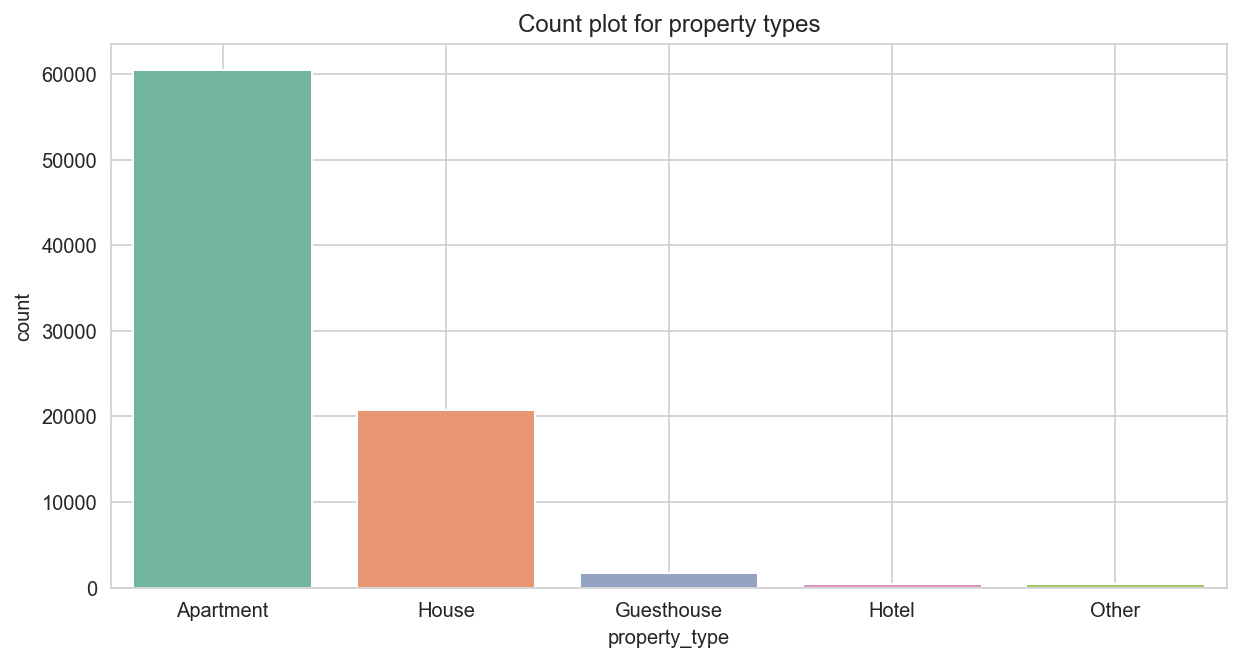

In [509]:
#plotting the count of properties types
fig, ax = plt.subplots(figsize= (10,5))
cnt_plot = sns.countplot(x = 'property_type', data=listings, palette = 'Set2')
ax.set_title(f'Count plot for property types')
ax.grid(True)


In [398]:
clean_df = listings.loc[(listings.price <= 600) & (listings.price > 0)]
sorted_price = clean_df.groupby('property_type')['price'].median()\
                 .sort_values(ascending=False).index

Text(0.5, 1.0, 'Box plot for the price per property type')

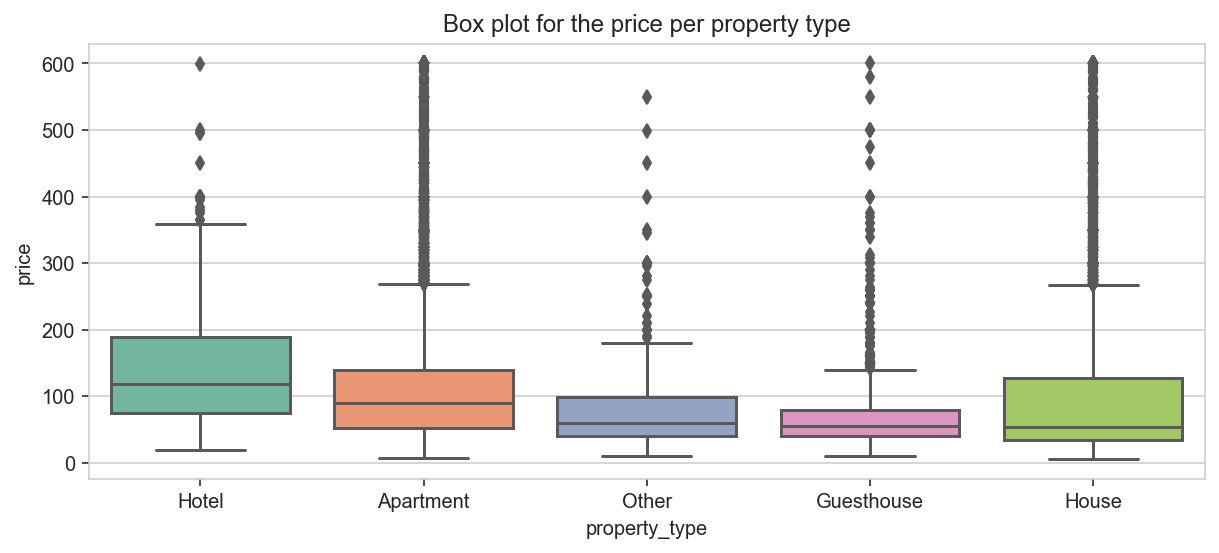

In [399]:
#plotting a box plot of the different propery types against the price  
fig, ax = plt.subplots(figsize=(10,4))
sns.boxplot(y='price', x= 'property_type', data=clean_df, order=sorted_price, palette = 'Set2')
ax.set_xticklabels(ax.get_xticklabels())
ax.set_title(f'Box plot for the price per property type')

# Some concluding remarks

- The dataset contains many NaN values (about a third of the dataset). The majority of missing data is in columns related to hosts. This could indicate that hosts are reluctant to provide required personal information.

- Westminister borough has the most expensive properties listed on Airbnb (Not a surprise as it is a prestigeous area with many national landmarks) followed by Kensington and Chelsea borough.

- Westminister as the most expensive borough received the highest number of reviews, yet it did not obtain the highest review score.

- Central London properties are generally more expensive. However, they generally obtain lower review score ranking by visitors.

- Richmond upon Thames  has the highest property ranking. 

- Review scores are within the range 90-100.

- The majority of properties have an average nightly price less than £100. with less properties as the price increases.

- Majority of hosts respond within an hour and distributed equally across London. However, hosts that reply later (within a day or a few days) are usually owners of properties in outer London. 

- Hotels have a higher median price than other accomodation/property types.

- Properties are cheaper to book around May.

---------------------------------------------------
#   Modelling
---------------------------------------------------

After removing redundant variables, here I prepare the data for my choice of machine learning model. Text and categorial variables are converted to numerical values below. 
The Machine learning model used is random forest regression and it evaluated using Revised Mean Sqaure Error RMSE and R-sqaured score

In [416]:
room_features = ['bathrooms', 'bedrooms']
host_features = ['host_is_superhost', 'host_identity_verified',
                'host_has_profile_pic', 'host_listings_count']

listings[room_features] = listings[room_features].fillna(listings[room_features].median())
listings.dropna(subset=host_features, inplace=True)

In [420]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83803 entries, 0 to 83849
Data columns (total 33 columns):
id                                  83803 non-null int64
host_id                             83803 non-null int64
host_response_time                  59068 non-null object
host_response_rate                  59068 non-null float64
host_is_superhost                   83803 non-null object
host_listings_count                 83803 non-null float64
host_has_profile_pic                83803 non-null object
host_identity_verified              83803 non-null object
neighbourhood_cleansed              83803 non-null object
latitude                            83803 non-null float64
longitude                           83803 non-null float64
property_type                       83803 non-null object
room_type                           83803 non-null object
accommodates                        83803 non-null int64
bathrooms                           83803 non-null float64
bedrooms           

In [466]:
listings_model = pd.read_csv('/Users/MarahFaroun/Downloads/listings.csv', low_memory=False)


In [467]:
listings_price = listings_model.price
listings_price = listings_price.apply(lambda x: x[1:])
listings_price = listings_price.apply(lambda x: x.replace(",", '')).astype('float64').replace(0.0, 0.01)
listings_price = np.log(listings_price)

In [468]:
listings_model.drop('price', axis=1, inplace=True)

In [469]:
class SelectCols(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            error_in_cols = list(set(self.columns) - set(X.columns))
            raise KeyError(f"Missing columns: {error_in_cols}")

In [477]:
class ChangeAment(BaseEstimator, TransformerMixin):
    def __init__(self, column='amenities'):
        self.column = column
        
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        
        X.loc[:, self.column] = X.loc[:, self.column].str.replace("[{}]", "").str.replace('"', "").str.strip()
        cnt_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(','))
        changed_column = cnt_vectorizer.fit_transform(X[self.column])
        change_column_todf = pd.DataFrame(changed_column.toarray(), columns=cnt_vectorizer.get_feature_names())
        change_column_todf = change_column_todf.drop('', axis=1)
        
        dropped_ament = []
        for col in change_column_todf.columns:
            if (change_column_todf[col].sum() / len(X) * 100) < 15:
                dropped_ament.append(col)
        
        change_column_todf.drop(dropped_ament, axis=1, inplace=True)
        
        return change_column_todf


In [ ]:
class ChangeNum(BaseEstimator, TransformerMixin):
    def __init__(self, price_vars, room_vars):
        self.price_vars = price_vars
        self.room_vars = room_vars

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        X.loc[:, self.price_vars] = X.loc[:, self.price_vars].apply(
            lambda x: x.str[1:])
        X.loc[:, self.price_vars] = X.loc[:, self.price_vars].apply(
            lambda x: x.str.replace(",", '')).astype('float64')
        X.loc[:, self.price_vars] = X.loc[:, self.price_vars].fillna(value=0)
        
        X.loc[:, self.room_vars] = X.loc[:, self.room_vars].fillna(
            X.loc[:, self.room_vars].median())
        
        X.loc[:, 'host_listings_count'] = X.loc[:, 'host_listings_count'].fillna(
            X.loc[:, 'host_listings_count'].median())
        
        return X

In [478]:
class ChangeCatg(BaseEstimator, TransformerMixin):
    # Class constructor method that takes in a list of values as its argument
    def __init__(self, features):
        self.features = features
    
    
    def discrete_bins_catg(self, df, col, bins, labels, na_label='unknown'):
        if df.loc[:, col].dtype == 'object':
            df.loc[:, col] = df.loc[:, col].str[:-1].astype('float64')

        df.loc[:, col] = pd.cut(df.loc[:, col], bins=bins,
                                labels=labels, include_lowest=True).astype('str')
        df.loc[:, col].replace('nan', 'unknown', inplace=True)
        df.loc[:, col].fillna(na_label, inplace=True)

        return df

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):

        X = self.discrete_bins_catg(X, 'host_response_rate',
                       bins=[0, 50, 75, 90, 100],
                       labels=['0-49%', '50-74%', '75-89%', '90-100%'])

        X = self.discrete_bins_catg(X, 'review_scores_rating',
                       bins=[0, 80, 95, 100],
                       labels=['0-79', '80-94', '95-100'],
                       na_label='no reviews')

        X.property_type.replace({
            'Townhouse': 'House',
            'Serviced apartment': 'Apartment',
            'Condominium': 'Apartment',
            'Bed and breakfast': 'Guesthouse',
            'Loft': 'Apartment',
            'Guest suite': 'Guesthouse',
            'Hostel': 'Guesthouse',
            'Boutique hotel': 'Hotel',
            'Bungalow': 'House',
            'Cottage': 'House',
            'Aparthotel': 'Hotel',
            'Cottage': 'House',
            'Aparthotel': 'Hotel',
            'Villa': 'House',
            'Tiny house': 'House',
            'Chalet': 'House',
            'Earth house': 'House',
            'Dome house': 'House'
        }, inplace=True)

        X.loc[~X.property_type.isin(
            ['House', 'Apartment', 'Guesthouse', 'Hotel']), 'property_type'] = 'Other'

        listings_model_ament = ChangeAment().fit_transform(X)

        X = pd.concat([X, listings_model_ament], axis=1, join='inner')
        X = X.drop('amenities', axis=1)
        for feat in self.features:
            X.loc[:, feat] = X.loc[:, feat].fillna(X.loc[:, feat].mode()[0])

        return X


In [479]:
features_cols = ['id', 'host_response_rate', 'host_is_superhost', 'host_listings_count',
                   'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed',
                   'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
                   'amenities', 'security_deposit', 'cleaning_fee', 'guests_included',
                   'extra_people', 'minimum_nights', 'maximum_nights', 'availability_90',
                   'number_of_reviews', 'review_scores_rating', 'requires_license',
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
                   'require_guest_profile_picture', 'require_guest_phone_verification']

room_feat = ['bathrooms', 'bedrooms']
price_feat = ['security_deposit', 'cleaning_fee', 'extra_people']
change_numerical = Pipeline(steps=[
    ('numchange', ChangeNum(price_feat, room_feat))
])

host_feat = ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic']
change_categorical = Pipeline(steps=[
    ('catchange', ChangeCatg(host_feat))
])



In [480]:
classifier = Pipeline(steps=[
    ('selectcolumn', SelectCols(features_cols)),
    ('categorical', change_categorical),
    ('numerical', change_numerical)
])

In [481]:
final_listings_model = classifier.fit_transform(listings_model)


/Users/MarahFaroun/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/MarahFaroun/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/Users/MarahFaroun/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pand

In [482]:
final_listings_model = final_listings_model.replace({'f': 0, 't': 1})

In [484]:
final_listings_model = pd.get_dummies(final_listings_model)

In [487]:
X_train, X_test, y_train, y_test = train_test_split(final_listings_model, listings_price, test_size=0.2,
                                                    random_state=42)

# Random Forest Regression
A random forest regressor is a metaestimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

In [489]:
#initiating and fitting the model
random_forest = RandomForestRegressor(n_estimators=500, 
                           random_state=42,
                           n_jobs=-1)
random_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [490]:
#function definition to evaluate the model performance
def EvaluateModel(model, X_test, y_test):
    predict_ylabels = model.predict(X_test)
    r_mse = (mean_squared_error(y_test, predict_ylabels))**0.5
    rsqaured = r2_score(y_test, predict_ylabels)
    adjusted_rsqaured = 1 - (1 - rsqaured) * (X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1)
    
    print(f'RMSE result: {r_mse}')
    print(f'R sqaured score result: {rsqaured}')
    print(f'Adjusted R sqaured score result: {adjusted_rsqaured}') 
    return r_mse, rsqaured

In [491]:
model_rmse, model_rsqaured = EvaluateModel(random_forest, X_test, y_test)

RMSE test: 0.39629254968294886
R sqaured score test: 0.7519794531123112
Adjusted R sqaured score test: 0.7502368153519304


In [494]:
predict = random_forest.predict(X_test)

In [495]:
print(predict)

[3.25096262 4.44135768 5.20937959 ... 4.91987326 4.02654605 4.37177776]


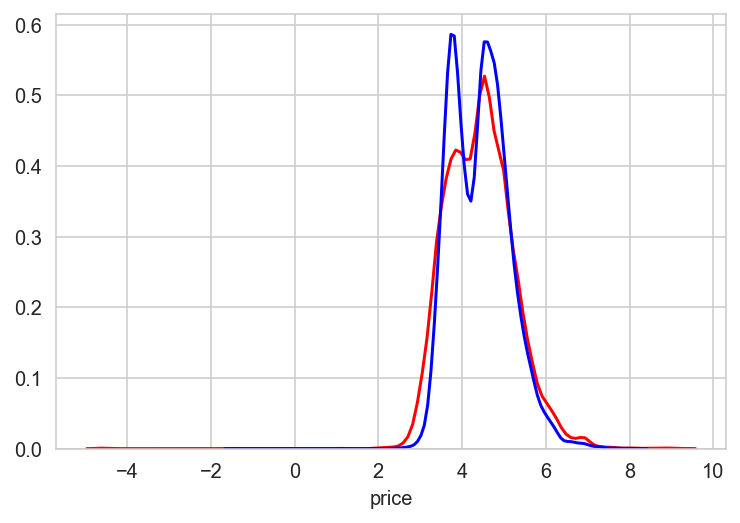

In [498]:
#plotting a curve to relate the actual log price and predicted log price
actual = sns.distplot(y_test, hist=False, color='r')
predicted = sns.distplot(predict, hist=False, color='b')

## Feature Importance

In [510]:
selected_feat = X_train.columns
feat_importance = pd.DataFrame(random_forest.feature_importances_,
                                        columns=['Importances'],
                                        index=selected_feat)

In [511]:
feat_importance.sort_values(by='Importances', ascending=False, inplace=True)

In [513]:
feat_importance.head(20)

,Importances
room_type_Entire home/apt,0.424371
bathrooms,0.092440
cleaning_fee,0.041305
host_listings_count,0.037981
availability_90,0.034827
id,0.033177
accommodates,0.032438
security_deposit,0.018003
number_of_reviews,0.017182
extra_people,0.015252


Most imporant features are listed above. Obviously renting an entire home rather than a single room in a shared accomodation is more expensive and affects price dramatically. More bathrooms also add great value to the worth of properties.
In addition, we see that the neighborhood is also a good predictor of price. Slightly less obvious is the relationship between host listing count and price. It is amongst the highly contributing features. This could maybe explained by assuming that these hosts are professional agencies thus are more costly than independent hosts.